# NIPS Tutorial

# Deep GP supervised learning

### Zhenwen Dai and Neil D. Lawrence

### Monday, 3rd December 2017

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

import GPy

import deepgp

import mlai
import teaching_plots as plot 
from gp_tutorial import ax_default, meanplot, gpplot

### Olympic Marathon Data

The first thing we will do is load a standard data set for regression modelling. The data consists of the pace of Olympic Gold Medal Marathon winners for the Olympics from 1896 to present. First we load in the data and plot.

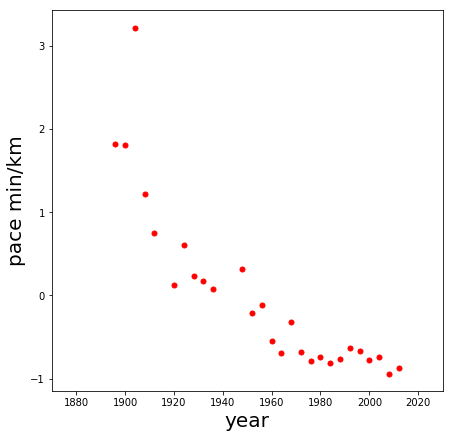

In [2]:
data = GPy.util.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

y = y - y.mean()
y = y/np.sqrt(y.var())
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim((1870,2030))
#ax.set_ylim((2.5,6.5))

plt.savefig('../../slides/diagrams/olympic-marathon.svg', transparent=True, frameon=True)


Things to notice about the data include the outlier in 1904, in this year, the olympics was in St Louis, USA. Organizational problems and challenges with dust kicked up by the cars following the race meant that participants got lost, and only very few participants completed. 

More recent years see more consistently quick marathons.

Our first objective will be to perform a Gaussian process fit to the data, we'll do this using the [GPy software](https://github.com/SheffieldML/GPy). 

In [3]:
m_full = GPy.models.GPRegression(x,y)
_ = m_full.optimize() # Optimize parameters of covariance function


The first command sets up the model, then 
```
m_full.optimize()
```
optimizes the parameters of the covariance function and the noise level of the model. Once the fit is complete, we'll try creating some test points, and computing the output of the GP model in terms of the mean and standard deviation of the posterior functions between 1870 and 2030. We plot the mean function and the standard deviation at 200 locations. We can obtain the predictions using
```
y_mean, y_var = m_full.predict(xt)
```

In [4]:
xt = np.linspace(1870,2030,200)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

Now we plot the results using the helper function ```gpplot```. 

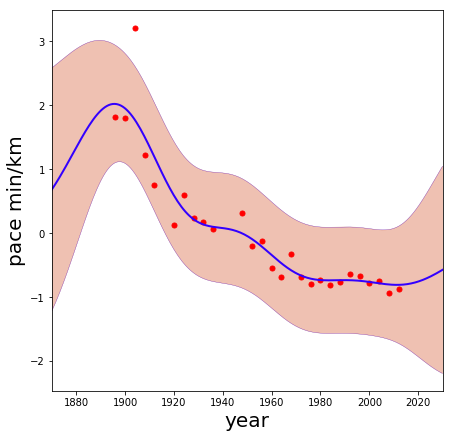

In [5]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)

_ = gpplot(xt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd, 
           ax=ax)

ax.set_xlim((1870,2030))
#ax.set_ylim((2.5,6.5))

plt.savefig('../../slides/diagrams/gp/olympic-marathon-gp.svg', 
            transparent=True, frameon=True)

### Fit Quality

In the fit we see that the error bars (coming mainly from the noise variance) are quite large. This is likely due to the outlier point in 1904, ignoring that point we can see that a tighter fit is obtained. To see this making a version of the model, ```m_clean```, where that point is removed. 

```
x_clean=np.vstack((x[0:2, :], x[3:, :]))
y_clean=np.vstack((y[0:2, :], y[3:, :]))

m_clean = GPy.models.GPRegression(x_clean,y_clean)
_ = m_clean.optimize()
```


### Deep GP Fit

Let's see if a deep Gaussian process can help here. We will construct a deep Gaussian process with one hidden layer (i.e. one Gaussian process feeding into another). 

Build a Deep GP with an additional hidden layer (one dimensional) to fit the model.

In [6]:
hidden = 1
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=y, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

Deep Gaussian process models also can require some thought in initialization. Here we choose to start by setting the noise variance to be one percent of the data variance.

Optimization requires moving variational parameters in the hidden layer representing the mean and variance of the expected values in that layer. Since all those values can be scaled up, and this only results in a downscaling in the output of the first GP, and a downscaling of the input length scale to the second GP. It makes sense to first of all fix the scales of the covariance function in each of the GPs.

Sometimes, deep Gaussian processes can find a local minima which involves increasing the noise level of one or more of the GPs. This often occurs because it allows a minimum in the KL divergence term in the lower bound on the likelihood. To avoid this minimum we habitually train with the likelihood variance (the noise on the output of the GP) fixed to some lower value for some iterations.

Let's create a helper function to initialize the models we use in the notebook.

In [7]:
#m.layer_1.kern.lengthscale=1

In [8]:
def initialize(self, noise_factor=0.01):
    """Helper function for deep model initialization."""
    self.obslayer.likelihood.variance = self.Y.var()*noise_factor

# Bind the new method to the Deep GP object.
deepgp.DeepGP.initialize=initialize

# Call the initalization
m.initialize()

In [9]:
m.layer_1.kern.lengthscale=10
m.obslayer.kern.lengthscale=0.1

Now optimize the model. The first stage of optimization is working on variational parameters and lengthscales only. 
```
m.optimize(messages=False,max_iters=100)
```

Now we remove the constraints on the scale of the covariance functions associated with each GP and optimize again.
```
for layer in m.layers:
    pass #layer.kern.variance.constrain_positive(warning=False)
m.obslayer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)
```

Finally, we allow the noise variance to change and optimize for a large number of iterations.
```
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)
```

For our optimization process we define a new function.

In [10]:
def staged_optimize(self, iters=(1000,1000,10000), messages=(False, False, True)):
    """Optimize with parameters constrained and then with parameters released"""
    for layer in self.layers:
        # Fix the scale of each of the covariance functions.
        layer.kern.variance.fix(warning=False)
        layer.kern.lengthscale.fix(warning=False)

        # Fix the variance of the noise in each layer.
        layer.likelihood.variance.fix(warning=False)

    self.optimize(messages=messages[0],max_iters=iters[0])
    
    for layer in self.layers:
        pass #layer.kern.variance.constrain_positive(warning=False)
        layer.kern.lengthscale.constrain_positive(warning=False)
    self.obslayer.kern.variance.constrain_positive(warning=False)


    self.optimize(messages=messages[1],max_iters=iters[1])

    for layer in self.layers:
        layer.likelihood.variance.constrain_positive(warning=False)
    self.optimize(messages=messages[2],max_iters=iters[2])
    
# Bind the new method to the Deep GP object.
deepgp.DeepGP.staged_optimize=staged_optimize

In [11]:
m.staged_optimize(messages=(True,True,True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0002   1.997545e+02   5.826204e+05 
    00s18  0003   1.935006e+02   3.913874e+05 
    02s19  0183   5.818666e+01   2.752660e+01 
    05s20  0446   5.609176e+01   3.755542e+02 
    10s88  1002   5.559677e+01   3.632016e+00 
Runtime:     10s88
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0002   8.806490e+01   8.293132e+05 
    00s17  0009   4.573726e+01   4.381369e+02 
    00s19  0010   4.532747e+01   4.051698e+02 
    04s22  0293   2.402507e+01   8.238443e+00 
    11s24  0899   2.111199e+01   3.914762e+00 
    12s27  1002   2.094403e+01   3.160412e+00 
Runtime:     12s27
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s11  00005   2.093998e+01   1.475585e+

In [12]:
m.obslayer.likelihood.variance

index,deepgp.obslayer.Gaussian_noise.variance,constraints,priors
[0],0.01191473,+ve,


### Plot the prediction

The prediction of the deep GP can be extracted in a similar way to the normal GP. Although, in this case, it is an approximation to the true distribution, because the true distribution is not Gaussian. 

In [13]:
yt_mean, yt_var = m.predict(xt)
yt_sd=np.sqrt(yt_var)

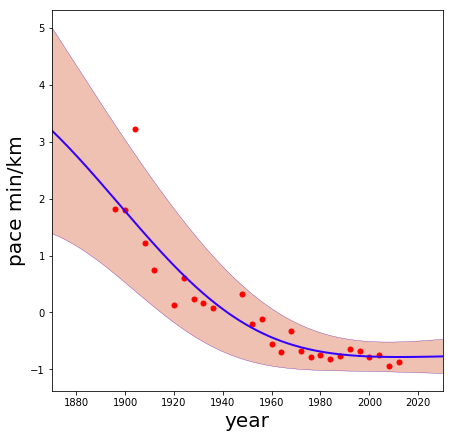

In [14]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)


_ = gpplot(xt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd,
           ax=ax)

ax.set_xlim((1870,2030))
#ax.set_ylim((2.5,6.5))

plt.savefig('../../slides/diagrams/deepgp/olympic-marathon-deep-gp.svg', 
            transparent=True, frameon=True)

### Fitted GP for each layer

Now we explore the GPs the model has used to fit each layer. First of all, we look at the hidden layer.

In [15]:
def visualize(self, xlabel='input', ylabel='output', 
              xlim=None, ylim=None, fontsize=20):
    """Visualize the layers in a deep GP with one-d input and output."""
    last_name = xlabel
    last_x = self.X
    for i, layer in enumerate(reversed(self.layers)):
        if i>0:
            plt.plot(last_x, layer.X.mean, 'r.',markersize=10)
            last_x=layer.X.mean

            name = 'layer ' + str(i)
            plt.xlabel(last_name, fontsize=fontsize)
            plt.ylabel(name, fontsize=fontsize)
            last_name=name

        xt = plot.pred_range(last_x)
        yt_mean, yt_var = layer.predict(xt)
        yt_sd = np.sqrt(yt_var)
        gpplot(xt,yt_mean,yt_mean-2*yt_sd,yt_mean+2*yt_sd)
        if i==0 and xlim is not None:
            pass
        
    plt.plot(last_x, self.Y, 'r.',markersize=10)
    plt.xlabel(last_name, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    if ylim is not None:
        pass

# Bind the new method to the Deep GP object.
deepgp.DeepGP.visualize=visualize


In [16]:
m.obslayer.posterior_samples?

In [17]:
def posterior_samples(self, X, size=1, **kwargs):
    """Visualize the layers in a deep GP with one-d input and output."""
    Z = X
    for i, layer in enumerate(reversed(self.layers)):
        if layer==self.obslayer:
            Z = layer.posterior_samples(Z, size=size, **kwargs)
        else:
            Z = layer.posterior_samples(Z, size=size, **kwargs)

 
        
    return Z
deepgp.DeepGP.posterior_samples = posterior_samples


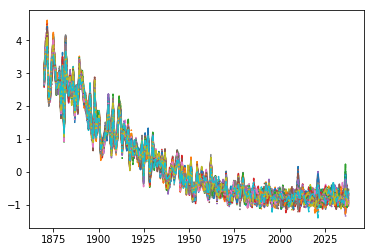

In [18]:
xt = plot.pred_range(m.X, portion=0.225)
samps=100
a=m.posterior_samples(xt, size=samps)
for i in range(samps):
    plt.plot(xt, a[:, i:i+1], '-.')

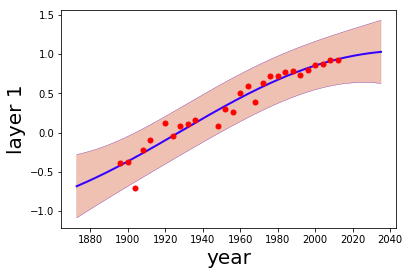

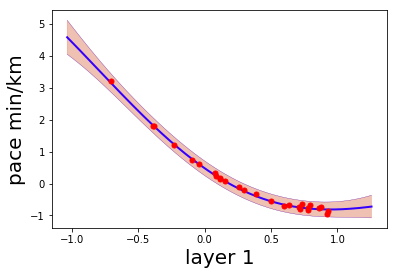

In [19]:
m.visualize(xlabel='year',ylabel='pace min/km',xlim=(1870,2030), ylim=(2.5,6.5))

In [20]:
zt_mean, zt_var = m.layer_1.predict(xt)
zt_sd = np.sqrt(zt_var)


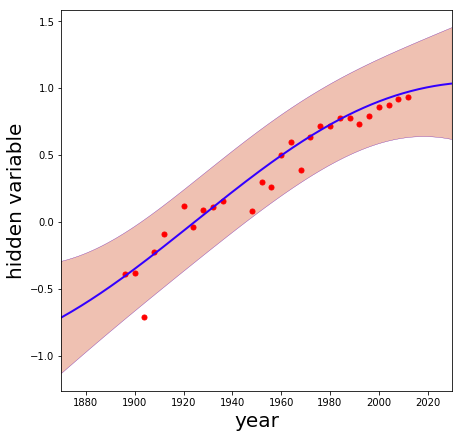

In [21]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, m.obslayer.X.mean, 'r.',markersize=10)
xt = np.linspace(1870,2030,200)[:,np.newaxis]

_ = gpplot(xt,
           zt_mean,
           zt_mean-2*zt_sd,
           zt_mean+2*zt_sd,
           ax=ax)


ax.set_ylabel('hidden variable', fontsize=20)
ax.set_xlabel('year', fontsize=20)
ax.set_xlim((1870,2030))
limz = ax.get_ylim()
plt.savefig('../../slides/diagrams/deepgp/olympic-marathon-deep-gp-layer-1.svg', transparent=True, frameon=True)


In [22]:
zt = np.linspace(limz[0]-0.1,limz[1]+0.1,200)[:,np.newaxis]
yt_mean, yt_var = m.obslayer.predict(zt)
yt_sd=np.sqrt(yt_var)

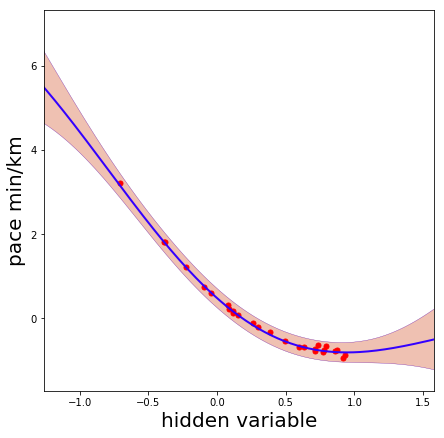

In [23]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.obslayer.X.mean, y, 'r.',markersize=10)

_ = gpplot(zt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd, 
           ax=ax)

ax.set_xlabel('hidden variable', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
#ax.set_ylim((2.5,6.5))
ax.set_xlim(limz)

plt.savefig('../../slides/diagrams/deepgp/olympic-marathon-deep-gp-layer-2.svg', transparent=True, frameon=True)

### Motorcycle Crash Data

Text(0,0.5,'acceleration')

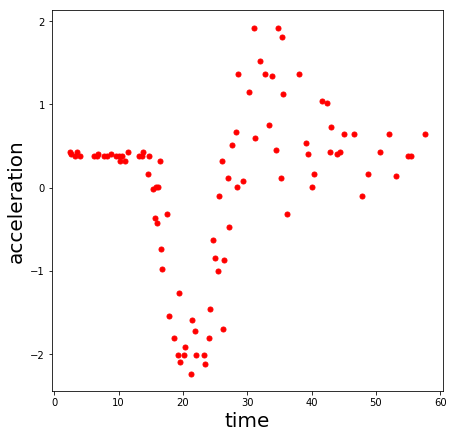

In [24]:
import pods
data = pods.datasets.mcycle()
x = data['X']
y = data['Y']
y = y - y.mean()
y = y/np.sqrt(y.var())
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('acceleration', fontsize=20)



In [25]:
layers = [y.shape[1], 1, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=y, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)



m.initialize()
for layer in m.layers:
    layer.likelihood.variance=0.001
    layer.kern.lengthscale = layer.kern.lengthscale/3
m.layers[-1].lengthscale = 5
    
plt.savefig('../../slides/diagrams/datasets/motorcycle-helmet.svg', 
            transparent=True, frameon=True)

In [26]:
m.staged_optimize(iters=(1000,1000,10000), messages=(True, True, True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0000   7.159544e+04           nan 
    00s12  0004   5.286021e+04   6.056881e+07 
    00s19  0008   4.785364e+04   6.354728e+06 
    02s20  0245   3.286658e+04   2.894080e+06 
    08s57  1002   3.241047e+04   5.819546e+04 
Runtime:     08s57
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   3.241047e+04   3.423093e+07 
    00s10  0006   3.157203e+04   1.089826e+07 
    00s19  0011   3.130718e+04   9.113202e+06 
    01s19  0125   1.072517e+03   1.902812e+06 
    02s20  0244   5.952304e+02   1.752255e+06 
    06s22  0551   4.256105e+02   6.397363e+05 
    10s29  1002   3.617868e+02   3.678694e+05 
Runtime:     10s29
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|       

In [27]:
m.obslayer.likelihood.variance

index,deepgp.obslayer.Gaussian_noise.variance,constraints,priors
[0],0.03326086,+ve,


In [28]:
xt = plot.pred_range(x, portion=0.5)
yt_mean, yt_var = m.predict(xt)
yt_sd=np.sqrt(yt_var)

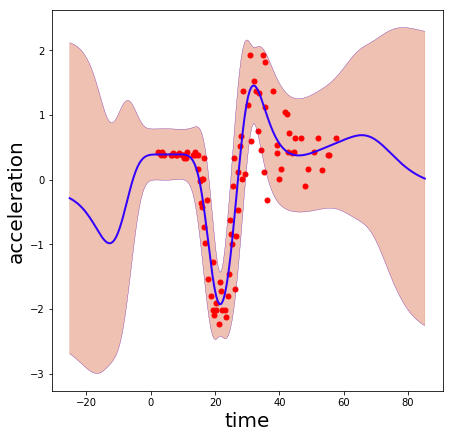

In [29]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('acceleration', fontsize=20)


_ = gpplot(xt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd,
           ax=ax)


plt.savefig('../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp.svg', 
            transparent=True, frameon=True)

In [30]:
m.obslayer.kern.lengthscale

index,deepgp.obslayer.rbf.lengthscale,constraints,priors
[0],0.40549825,+ve,


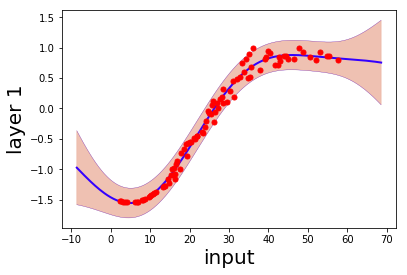

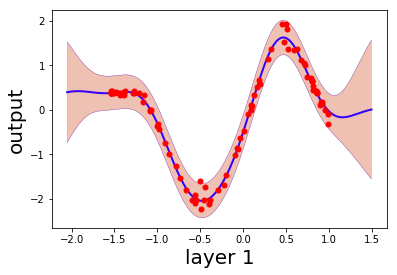

In [31]:
m.visualize()

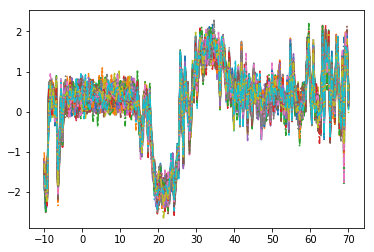

In [32]:
xt = plot.pred_range(m.X, portion=0.225)
samps=100
a=m.posterior_samples(xt, size=samps)
for i in range(samps):
    plt.plot(xt, a[:, i:i+1], '-.')

### Robot Wireless Data

The robot wireless data is taken from an experiment run by Brian Ferris at University of Washington. It consists of the measurements of WiFi access point signal strengths as Brian walked in a loop.

In [33]:
data=pods.datasets.robot_wireless()

x = np.linspace(0,1,215)[:, np.newaxis]
y = data['Y']

The ground truth is recorded in the data, the actual loop is given in the plot below.

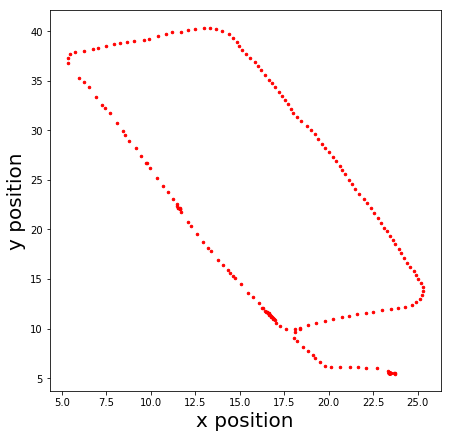

In [34]:
f, ax = plt.subplots(figsize=plot.big_figsize)
plt.plot(data['X'][:, 1], data['X'][:, 2], 'r.', markersize=5)
ax.set_xlabel('x position', fontsize=20)
ax.set_ylabel('y position', fontsize=20)
plt.savefig('../../slides/diagrams/datasets/robot-wireless-ground-truth.svg', transparent=True, frameon=True)

We will ignore this ground truth in making our predictions, but see if the model can recover something similar in one of the latent layers.

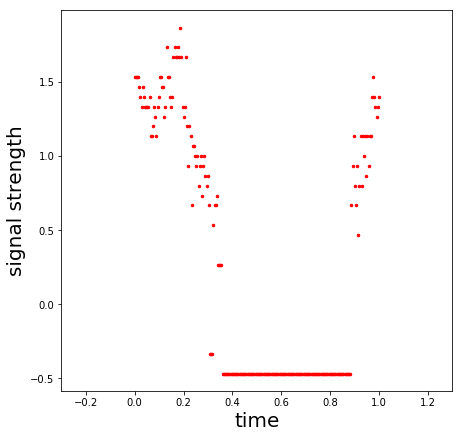

In [35]:
output_dim=1
xlim = (-0.3, 1.3)
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y[:, output_dim:output_dim+1], 
            'r.', markersize=5)

ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)

ax.set_xlim(xlim)
ylim = ax.get_ylim()
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/datasets/robot-wireless-dim-' + str(output_dim) + '.svg', 
            transparent=True, frameon=True)

Perform a Gaussian process fit on the data using GPy.

In [36]:
m_full = GPy.models.GPRegression(x,y[:, output_dim:output_dim+1])
_ = m_full.optimize() # Optimize parameters of covariance function


In [37]:
xt = np.linspace(xlim[0], xlim[1],200)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

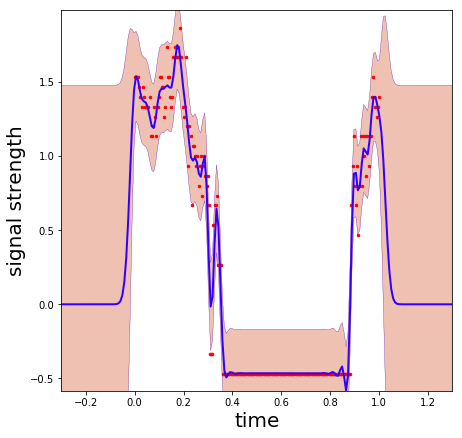

In [38]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y[:, output_dim:output_dim+1], 'r.',markersize=5)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)

_ = gpplot(xt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd, 
           ax=ax)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/gp/robot-wireless-gp-dim-' + str(output_dim) + '.svg', transparent=True, frameon=True)

In [ ]:
layers = [y.shape[1], 10, 5, 5, 2, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]

In [ ]:
m = deepgp.DeepGP(layers,Y=y, X=x, inits=inits, 
                  kernels=kernels,
                  num_inducing=50, back_constraint=False)
m.initialize()
m.layers[-1].kern.lengthscale=10
m.staged_optimize(messages=(True,True,True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s20  0009   1.330274e+05   1.066527e+08 
    02s25  0018   1.022715e+05   6.236840e+07 
    09s65  0072   2.388749e+04   1.106341e+07 
    12s85  0099   1.209025e+04   5.354196e+06 
    18s19  0136   6.520977e+03   2.104260e+06 
    29s98  0228   3.586606e+03   1.052571e+05 
 01m14s42  0567   1.048862e+03   6.596709e+05 
 01m32s35  0704   3.028955e+02   2.184713e+04 
 01m58s98  0910   1.471831e+02   1.555286e+03 
 02m10s92  1002   1.299096e+02   7.136663e+02 
Runtime:  02m10s92
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0000   1.299096e+02   7.136663e+02 
    02s24  0018  -1.370966e+02   6.929579e+04 
    09s63  0072  -6.017610e+02   1.170288e+04 
    29s72  0225  -1.243967e+03   3.982531e+03 
    32s92  0252  -1.276991e+03   3.247555e+03 
 01m24s34  0643  -1.392411e+03

In [ ]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.layers[-4].latent_space.mean[:, 2], 
        m.layers[-4].latent_space.mean[:, 3], 
        'r.-', markersize=5)

ax.set_xlabel('latent dimension 1', fontsize=20)
ax.set_ylabel('latent dimension 2', fontsize=20)

plt.savefig('../../slides/diagrams/deepgp/robot-wireless-latent-space.svg', 
            transparent=True, frameon=True)

In [ ]:
for layer in m.layers:
    print(layer.kern.lengthscale)

In [ ]:
xt = np.linspace(xlim[0],xlim[1],200)[:,np.newaxis]
yt_mean, yt_var = m.predict(xt)
yt_sd=np.sqrt(yt_var)


In [ ]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y[:, output_dim:output_dim+1], 'r.',markersize=5)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)

_ = gpplot(xt,yt_mean[:, output_dim:output_dim+1],
           yt_mean[:, output_dim:output_dim+1]-2*yt_sd[:, output_dim:output_dim+1],
           yt_mean[:, output_dim:output_dim+1]+2*yt_sd[:, output_dim:output_dim+1], ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/deepgp/robot-wireless-deep-gp-dim-' + str(output_dim) + '.svg', 
            transparent=True, frameon=True)

# Step Function

Finally, we consider a simple step function data set. 

In [ ]:
num_data=50
x = np.linspace(-1, 1, num_data)[:, np.newaxis]
y = (x>0) + np.random.randn(num_data, 1)*0.01

In [ ]:
plt.plot(x, y, 'r.')

In [ ]:
layers = [y.shape[1], 1, 1, 1, 1, 1, 1, 1,x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=y, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)

In [ ]:
m.initialize()


In [ ]:
m.visualize()

In [ ]:
m.optimize(messages=False,max_iters=100)
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=1000)

In [ ]:
xt = np.linspace(x.min()*2,x.max()*2,200)[:,np.newaxis]
yt_mean, yt_var = m.predict(xt)
yt_sd = np.sqrt(yt_var)

In [ ]:
_ = gpplot(xt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd)

plt.plot(x,y,'rx')


In [ ]:
m.visualize()

In [ ]:
layer.name

In [ ]:
gpplot(xt,yt_mean,yt_mean-2*yt_sd,yt_mean+2*yt_sd)
plt.plot(x, m.layer_6.X.mean, 'r.',markersize=10)

plt.xlabel('input')
_=plt.ylabel('hidden layer 6')

In [ ]:
yt_mean, yt_var = m.layer_6.predict(xt)
yt_sd = np.sqrt(yt_var)

In [ ]:
gpplot(xt,yt_mean,yt_mean-2*yt_sd,yt_mean+2*yt_sd)
plt.plot(m.layer_6.X.mean, m.layer_5.X.mean, 'r.',markersize=10)
plt.xlabel('hidden 6')
_=plt.ylabel('hidden 5')

In [ ]:
yt_mean, yt_var = m.layer_5.predict(xt)
yt_sd = np.sqrt(yt_var)

In [ ]:
gpplot(xt,yt_mean,
       yt_mean-2*yt_sd,
       yt_mean+2*yt_sd)
plt.plot(m.layer_5.X.mean, m.layer_4.X.mean, 'r.',markersize=10)
plt.xlabel('hidden 5')
_=plt.ylabel('hidden 4')

In [ ]:
yt_mean, yt_var = m.layer_4.predict(xt)
yt_sd = np.sqrt(yt_var)

In [ ]:
gpplot(xt,yt_mean,
       yt_mean-2*yt_sd,
       yt_mean+2*yt_sd)
plt.plot(m.layer_4.X.mean, m.layer_3.X.mean, 'r.',markersize=10)
plt.xlabel('hidden 4')
_=plt.ylabel('hidden 3')

In [ ]:
yt_mean, yt_var = m.layer_3.predict(xt)
yt_sd = np.sqrt(yt_var)

In [ ]:
gpplot(xt,yt_mean,
       yt_mean-2*yt_sd,
       yt_mean+2*yt_sd)
plt.plot(m.layer_3.X.mean, m.layer_2.X.mean, 'r.',markersize=10)
plt.xlabel('hidden 3')
_=plt.ylabel('hidden 2')